<a href="https://colab.research.google.com/github/franmazzaro/7506R-2C2023-GRUPO39/blob/main/7506R_TP2_GRUPO39_CHP1_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerias**

Empezamos importando las librerias que vamos a utilizar

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Nadam

# Carga de datasets

In [20]:
df_criticas = pd.read_csv('/content/sample_data/train.csv')
df_criticas_test = pd.read_csv('/content/sample_data/test.csv')


In [21]:
df_criticas.head(4)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo


# Preprocesamiento

Comenzamos el preprocesamiento vectorizando las reviews del dataset de train y test asi convertimos las criticas de texto a una representacion numerica.


Tambien hacemos lo mismo para transformar los sentimientos "positivo" y "negativo"

Dividimos nuestro dataset de train en 70% para entrenar y 30% para validar.


In [22]:
# Vectorización de texto usando CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_criticas['review_es'])
X_test = vectorizer.transform(df_criticas_test['review_es'])

# Codificar las etiquetas de sentimiento
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_criticas['sentimiento'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=25)

In [23]:
# Función para convertir valores
def convertir(valor):
    return "negativo" if valor == 0 else "positivo"

Esta funcion transforma de numerico a String el sentimiento

In [24]:
def mostrar_metricas(y_test, y_pred):
  #Cantidad de aciertos
  print('correctas: ', np.sum(y_test == y_pred))
  print('total: ', len(y_test))

  print(classification_report(y_test, y_pred))

  #Grafico la matriz de confusión
  tabla=confusion_matrix(y_test, y_pred)
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


# Bayes Naive

Dividimos nuestro conjunto de train en 70 30

In [ ]:
x_train_bayes, x_test_bayes, y_train_bayes, y_test_bayes = train_test_split(df_criticas.review_es,
                                                    df_criticas.sentimiento,
                                                    test_size=0.20,
                                                    random_state=25,
                                                    shuffle=True)

Antes de entrear un modelo para clasificacion necesitamos que este entrenamiento sea con valores numericos, y como nosotros tenemos palabras necesitamos convertirlas a vectores.

Utilizamos make_pipeline para aplicarle a nuestros modelos dos metodos distintos para vectorizar y luego el modelo de Naive Bayes Multidimensional. Una vez obtenidos los entrenamos

In [ ]:
model_NB = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_NB_2 = make_pipeline(CountVectorizer(), MultinomialNB())

model_NB.fit(x_train_bayes, y_train_bayes)
model_NB_2.fit(x_train_bayes, y_train_bayes)

categorias_predichas = model_NB.predict(x_test_bayes)
categorias_predichas_2 = model_NB_2.predict(x_test_bayes)


In [ ]:
print(accuracy_score(y_test_bayes, categorias_predichas))
print(accuracy_score(y_test_bayes, categorias_predichas_2))

0.8534666666666667
0.8376


Ya que el modelo 1 tuvo mejor accuracy es el que utilizamos para realizar la predicción de test

## Predicción sobre los datos de test

In [ ]:
criticas_test = df_criticas_test['review_es']
categorias_predichas_test = model_NB.predict(criticas_test)


Generamos el archivo de predicciones

In [ ]:
ids_test =  df_criticas_test.ID
filename = 'Naive_Bayes_Multidimensional'
prediccion = pd.DataFrame({"id": ids_test, "sentimiento": categorias_predichas_test})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

# Random Forest

Optimizamos hiperparámetros

In [ ]:
tree = RandomForestClassifier(random_state=1)
params_grid = {
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.01, 0.02],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100, 200],
}
rand = RandomizedSearchCV(tree, params_grid, cv=10, scoring='f1', n_iter=10, random_state=1)
rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

In [ ]:
rand.best_params_

Usamos el mejor estimador para predecir sobre el conjunto de training y obtenemos sus métricas

In [ ]:
opt_tree = rand.best_estimator_
y_pred = opt_tree.predict(x_test)
print(classification_report(y_test, y_pred))

## Predicción sobre los datos de test

In [ ]:
categorias_predichas_test = opt_tree.predict(X_test)

# Aplicar la función a cada elemento del array usando comprensión de listas
sentimientos = [convertir(valor) for valor in categorias_predichas_test]

In [ ]:
filename = 'Random_Forest_opt'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": sentimientos})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

# XG Boost

Utilizamos un clasificador XGBoost para entrenar nuestro modelo

In [25]:
xg_boost_model = xgb.XGBClassifier(random_state=25, n_estimators=100)
xg_boost_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=25, ...)

In [26]:
y_pred = xg_boost_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      7599
           1       0.82      0.86      0.84      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



correctas:  12561
total:  15000
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      7599
           1       0.82      0.86      0.84      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



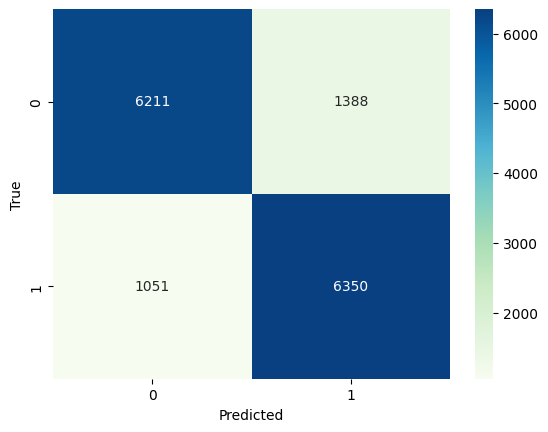

In [27]:
mostrar_metricas(y_test, y_pred)

In [28]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Tasa de aprendizaje
    'max_depth': [3, 4, 5, 6, 7, 8, 9],  # Profundidad máxima del árbol
    'min_child_weight': [1, 2, 3, 4],  # Mínimo peso de un niño (para evitar divisiones adicionales)
    'subsample': [0.8, 0.9, 1.0],  # Proporción de muestras utilizadas para entrenar árboles
    'colsample_bytree': [0.8, 0.9, 1.0],  # Proporción de características utilizadas para entrenar árboles
    'gamma': [0, 0.1, 0.2, 0.3],  # Parámetro de regularización para la poda
    'n_estimators': [100, 200, 300],  # Número de árboles (estimadores) en el bosque
}

# Inicializa el clasificador XGBoost
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

# Realiza la búsqueda de hiperparámetros utilizando RandomizedSearchCV
n_iter = 10  # Número de combinaciones aleatorias a probar
xgb_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist, n_iter=n_iter, scoring='f1', cv=5, random_state=0)

# Ajusta el modelo a los datos de entrenamiento
xgb_search.fit(x_train, y_train)

xgb_search.best_params_

{'subsample': 1.0,
 'n_estimators': 300,
 'min_child_weight': 4,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'colsample_bytree': 1.0}

Colocamos varios parametros para utilizar un RandomizedSearchCV y asi encontrar los mejores hiperparametros usando f1 como score ya que este se utiliza para medir en Kaggle y luego entrenamos el modelo

In [ ]:
opt_xg = xgb_search.best_estimator_
y_pred = opt_xg.predict(x_test)
print(classification_report(y_test, y_pred))
mostrar_metricas(y_test, y_pred)

Vemos que

## Predicción sobre los datos de test

In [ ]:
categorias_predichas_test_xg = opt_xg.predict(X_test)

# Aplicar la función a cada elemento del array usando comprensión de listas
sentimientos = [convertir(valor) for valor in categorias_predichas_test_xg]

In [ ]:
filename = 'Xg_Boost_opt'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": sentimientos})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

Exportamos el csv para subir a Kaggle

# Red neuronal (Keras Tensorflow)

## Modelo 1

Maxlen=1000

In [ ]:
# Tokenización y secuenciación de texto en los datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_bayes)

X_train_seq = tokenizer.texts_to_sequences(x_train_bayes)  # Convertir texto a secuencias
X_test_seq = tokenizer.texts_to_sequences(x_test_bayes)

X_train_pad = pad_sequences(X_train_seq, maxlen=1000)  # Ajustar secuencias a una longitud máxima de 1000
X_test_pad = pad_sequences(X_test_seq, maxlen=1000)

encoder = LabelEncoder()
y_train_binario = encoder.fit_transform(y_train_bayes) # Enconding de la columna sentimiento
y_test_binario = encoder.transform(y_test_bayes)


In [ ]:
# Crear el modelo de red neuronal
model_1 = Sequential()
model_1.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=1000))  # Capa de embedding
model_1.add(Flatten())  # Aplanar la salida de la capa de embedding
model_1.add(Dense(16, activation='relu'))  # Capa densa con activación ReLU
model_1.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria


Embedding es una capa de procesamiento fundamental para el manejo de texto en redes neuronales. Esta capa se utiliza para convertir representaciones numéricas de palabras (índices enteros) en vectores densos de longitud fija.


El primer argumento, len(tokenizer.word_index) + 1, especifica el tamaño del vocabulario de entrada. tokenizer.word_index contiene un diccionario que asigna palabras a índices numéricos, y sumar 1 se hace porque generalmente se reserva un índice para palabras fuera del vocabulario o para el relleno.

El segundo argumento, 32, representa la dimensionalidad de los vectores de embedding. En este caso, cada palabra se representará mediante un vector de 32 dimensiones.


In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model_1.fit(X_train_pad, y_train_binario, epochs=5, batch_size=32, validation_split=0.2)
y_pred = model_1.predict(X_test_pad)


Epoch 1/5
875/875 [==============================] - 114s 128ms/step - loss: 0.3813 - accuracy: 0.8251 - val_loss: 0.2848 - val_accuracy: 0.8827
Epoch 2/5
875/875 [==============================] - 100s 115ms/step - loss: 0.0721 - accuracy: 0.9785 - val_loss: 0.3273 - val_accuracy: 0.8733
Epoch 3/5
875/875 [==============================] - 100s 114ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.3954 - val_accuracy: 0.8726
Epoch 4/5
875/875 [==============================] - 126s 143ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4239 - val_accuracy: 0.8756
Epoch 5/5
469/469 [==============================] - 3s 7ms/step


Definimos el optimizador, probamos usando adam y usamos loss = binary_crossentropy ya que estamos en un problema de clasificacion binario.

correctas:  13092
total:  15000
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7599
           1       0.86      0.88      0.87      7401

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



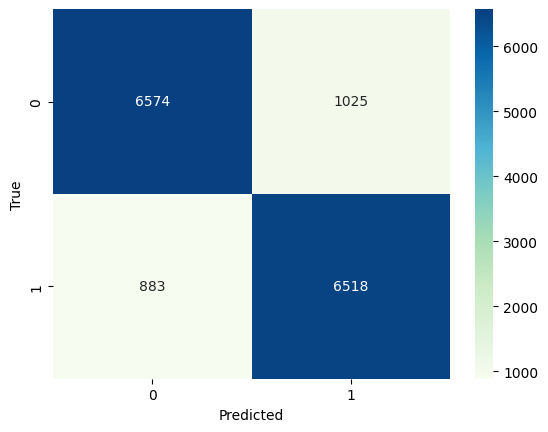

In [ ]:
threshold = 0.5
predicted_sentiments = [1 if pred > threshold else 0 for pred in y_pred]
mostrar_metricas(y_test_binario, predicted_sentiments)

## Predicción sobre los datos de test

In [ ]:
# Preprocesamiento de los datos de prueba
X_test = df_criticas_test['review_es']  # Datos de texto de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convertir texto a secuencias para datos de prueba
X_test_pad = pad_sequences(X_test_seq, maxlen=1000)  # Ajustar secuencias a una longitud máxima de 1000 para datos de prueba

# Predicción en el conjunto de prueba
predictions = model_1.predict(X_test_pad)

# Ajustar un umbral para determinar las clases basadas en las probabilidades
threshold = 0.5
predicted_sentiments = ['positivo' if pred > threshold else 'negativo' for pred in predictions]

In [ ]:
filename = 'tensorflow_2'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

## Modelo 2

Maxlen=1500

learning_rate=0.001

In [ ]:
# Tokenización y secuenciación de texto en los datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_bayes)

X_train_seq = tokenizer.texts_to_sequences(x_train_bayes)  # Convertir texto a secuencias
X_test_seq = tokenizer.texts_to_sequences(x_test_bayes)

X_train_pad = pad_sequences(X_train_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)

encoder = LabelEncoder()
y_train_binario = encoder.fit_transform(y_train_bayes) # Enconding de la columna sentimiento
y_test_binario = encoder.transform(y_test_bayes)


In [ ]:
# Crear el modelo de red neuronal
model_2 = Sequential()
model_2.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=1500))  # Capa de embedding
model_2.add(Flatten())  # Aplanar la salida de la capa de embedding
model_2.add(Dense(16, activation='relu'))  # Capa densa con activación ReLU
model_2.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria


In [ ]:
model_2.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model_2.fit(X_train_pad, y_train_binario, epochs=5, batch_size=32, validation_split=0.2)
y_pred = model_2.predict(X_test_pad)


Epoch 1/5
875/875 [==============================] - 141s 155ms/step - loss: 0.6938 - accuracy: 0.5050 - val_loss: 0.6937 - val_accuracy: 0.4860
Epoch 2/5
875/875 [==============================] - 132s 151ms/step - loss: 0.6928 - accuracy: 0.5073 - val_loss: 0.6936 - val_accuracy: 0.4861
Epoch 3/5
875/875 [==============================] - 130s 149ms/step - loss: 0.4267 - accuracy: 0.7746 - val_loss: 0.3007 - val_accuracy: 0.8753
Epoch 4/5
875/875 [==============================] - 131s 150ms/step - loss: 0.0885 - accuracy: 0.9707 - val_loss: 0.3363 - val_accuracy: 0.8710
Epoch 5/5
469/469 [==============================] - 3s 6ms/step


correctas:  13085
total:  15000
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      7599
           1       0.89      0.85      0.87      7401

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



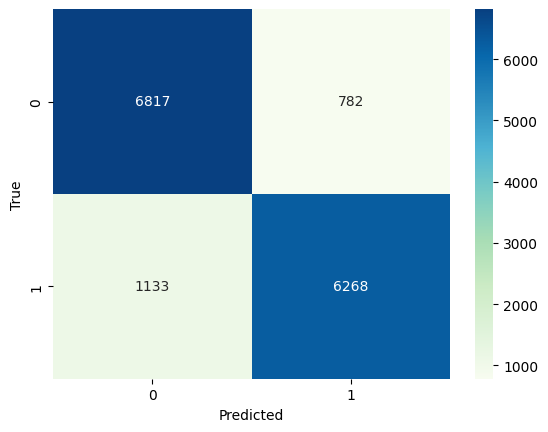

In [ ]:
threshold = 0.5
predicted_sentiments = [1 if pred > threshold else 0 for pred in y_pred]
mostrar_metricas(y_test_binario, predicted_sentiments)

In [ ]:
# Preprocesamiento de los datos de prueba
X_test = df_criticas_test['review_es']  # Datos de texto de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convertir texto a secuencias para datos de prueba
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500 para datos de prueba

# Predicción en el conjunto de prueba
predictions = model_2.predict(X_test_pad)

# Ajustar un umbral para determinar las clases basadas en las probabilidades
threshold = 0.5
predicted_sentiments = ['positivo' if pred > threshold else 'negativo' for pred in predictions]

269/269 [==============================] - 2s 6ms/step


In [ ]:
filename = 'tensorflow_4'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

## Modelo 2 con más épocas

In [ ]:
# Tokenización y secuenciación de texto en los datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_bayes)

X_train_seq = tokenizer.texts_to_sequences(x_train_bayes)  # Convertir texto a secuencias
X_test_seq = tokenizer.texts_to_sequences(x_test_bayes)

X_train_pad = pad_sequences(X_train_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)

encoder = LabelEncoder()
y_train_binario = encoder.fit_transform(y_train_bayes) # Enconding de la columna sentimiento
y_test_binario = encoder.transform(y_test_bayes)


In [ ]:
# Crear el modelo de red neuronal
model_3 = Sequential()
model_3.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=1500))  # Capa de embedding
model_3.add(Flatten())  # Aplanar la salida de la capa de embedding
model_3.add(Dense(16, activation='relu'))  # Capa densa con activación ReLU
model_3.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria


In [ ]:
model_3.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model_3.fit(X_train_pad, y_train_binario, epochs=50, batch_size=32, validation_split=0.2)
y_pred = model_3.predict(X_test_pad)


Epoch 1/50
875/875 [==============================] - 90s 101ms/step - loss: 0.4163 - accuracy: 0.7969 - val_loss: 0.2797 - val_accuracy: 0.8849
Epoch 2/50
875/875 [==============================] - 87s 100ms/step - loss: 0.1195 - accuracy: 0.9574 - val_loss: 0.3119 - val_accuracy: 0.8790
Epoch 3/50
875/875 [==============================] - 87s 100ms/step - loss: 0.0177 - accuracy: 0.9967 - val_loss: 0.3891 - val_accuracy: 0.8753
Epoch 4/50
875/875 [==============================] - 86s 98ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.4391 - val_accuracy: 0.8739
Epoch 5/50
875/875 [==============================] - 86s 98ms/step - loss: 6.1663e-04 - accuracy: 1.0000 - val_loss: 0.4712 - val_accuracy: 0.8744
Epoch 6/50
875/875 [==============================] - 85s 97ms/step - loss: 1.9912e-04 - accuracy: 1.0000 - val_loss: 0.5029 - val_accuracy: 0.8740
Epoch 7/50
875/875 [==============================] - 86s 98ms/step - loss: 9.6935e-05 - accuracy: 1.0000 - val_loss: 0.5295 

correctas:  13215
total:  15000
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7599
           1       0.89      0.87      0.88      7401

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



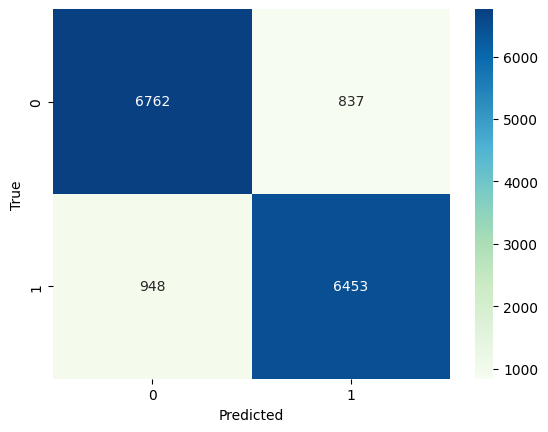

In [ ]:
threshold = 0.5
predicted_sentiments = [1 if pred > threshold else 0 for pred in y_pred]
mostrar_metricas(y_test_binario, predicted_sentiments)

In [ ]:
# Preprocesamiento de los datos de prueba
X_test = df_criticas_test['review_es']  # Datos de texto de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convertir texto a secuencias para datos de prueba
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500 para datos de prueba

# Predicción en el conjunto de prueba
predictions = model_3.predict(X_test_pad)

# Ajustar un umbral para determinar las clases basadas en las probabilidades
threshold = 0.5
predicted_sentiments = ['positivo' if pred > threshold else 'negativo' for pred in predictions]

269/269 [==============================] - 1s 5ms/step


In [ ]:
filename = 'tensorflow_5'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

Kaggle da 0.73657 así que empeoró con 50 épocas